In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hnscc-zip/HNSCC_data/cd.ipynb
/kaggle/input/hnscc-zip/HNSCC_data/clinical.csv
/kaggle/input/hnscc-zip/HNSCC_data/code.ipynb
/kaggle/input/hnscc-zip/HNSCC_data/data.csv
/kaggle/input/hnscc-zip/HNSCC_data/ct_images/HNSCC-01-0378_ct_images/1-226.png
/kaggle/input/hnscc-zip/HNSCC_data/ct_images/HNSCC-01-0378_ct_images/1-066.png
/kaggle/input/hnscc-zip/HNSCC_data/ct_images/HNSCC-01-0378_ct_images/1-092.png
/kaggle/input/hnscc-zip/HNSCC_data/ct_images/HNSCC-01-0378_ct_images/1-072.png
/kaggle/input/hnscc-zip/HNSCC_data/ct_images/HNSCC-01-0378_ct_images/1-099.png
/kaggle/input/hnscc-zip/HNSCC_data/ct_images/HNSCC-01-0378_ct_images/1-209.png
/kaggle/input/hnscc-zip/HNSCC_data/ct_images/HNSCC-01-0378_ct_images/1-271.png
/kaggle/input/hnscc-zip/HNSCC_data/ct_images/HNSCC-01-0378_ct_images/1-247.png
/kaggle/input/hnscc-zip/HNSCC_data/ct_images/HNSCC-01-0378_ct_images/1-273.png
/kaggle/input/hnscc-zip/HNSCC_data/ct_images/HNSCC-01-0378_ct_images/1-122.png
/kaggle/input/hnscc-zip/HNSC

Build a mapping of images to clinical data

In [4]:
import os

root_image_dir = "/kaggle/input/hnscc-zip/HNSCC_data/ct_images/"
patient_folders = os.listdir(root_image_dir)

# Example mapping
patient_id_map = {folder: folder.replace('_ct_images','') for folder in patient_folders}

# Now you can join clinical_df on this patient ID


2D images to 3D

In [6]:
import numpy as np
from PIL import Image

def load_patient_volume(patient_folder):
    slices = sorted(os.listdir(patient_folder))
    volume = []
    for s in slices:
        img = Image.open(os.path.join(patient_folder, s)).convert('L')
        volume.append(np.array(img))
    return np.stack(volume, axis=0)


In [7]:
import pandas as pd
import os

# Define paths
clinical_csv_path = "/kaggle/input/hnscc-zip/HNSCC_data/clinical.csv"
image_root = "/kaggle/input/hnscc-zip/HNSCC_data/ct_images/"

# Load clinical data
clinical = pd.read_csv(clinical_csv_path)
print(f"Clinical rows before filtering: {len(clinical)}")

# Get patient IDs from image folders
image_folders = os.listdir(image_root)
image_patient_ids = [folder.replace('_ct_images', '') for folder in image_folders]

print(f"Number of patient image folders: {len(image_patient_ids)}")
print("Sample patient IDs with images:", image_patient_ids[:5])

# Filter
clinical_id_column = 'TCIA Radiomics dummy ID of Merged updated ASRM V2'
clinical_with_images = clinical[clinical[clinical_id_column].isin(image_patient_ids)]

print(f"Clinical rows after filtering: {len(clinical_with_images)}")

# Save as clinical1.csv
clinical_with_images.to_csv('clinical1.csv', index=False)
print("✅ Saved as clinical1.csv")


Clinical rows before filtering: 492
Number of patient image folders: 336
Sample patient IDs with images: ['HNSCC-01-0378', 'HNSCC-01-0519', 'HNSCC-01-0510', 'HNSCC-01-0579', 'HNSCC-01-0535']
Clinical rows after filtering: 335
✅ Saved as clinical1.csv


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
df = pd.read_csv("clinical1.csv")
# Load and clean dataset
clinical = pd.read_csv(clinical_csv_path)
df.dropna(inplace=True)

# Bin continuous target into categories
bins = [0,60, 62.5, 65,67.5, 70, 72.5,float('inf')]
labels = ['L1', 'L2', 'L3','L4', 'L5', 'L6','L7']
df['DoseCategory'] = pd.cut(df['Total prescribed Radiation treatment dose'], bins=bins, labels=labels, right=True)

# Drop original continuous target and irrelevant columns
columns_to_drop = [
    "Total prescribed Radiation treatment dose",
    "Radiation Treatment_duration",
    "Radiation treatment_number of fractions",
    "Radiation treatment_dose per fraction",
    "TCIA Radiomics dummy ID of To_Submit_Final",
    "TCIA Radiomics dummy ID of Merged updated ASRM V2"
]
df = df.drop(columns=columns_to_drop)
df.dropna(inplace=True)

# Encode categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Features and target
X = df.drop(columns=['DoseCategory'])
y = df['DoseCategory']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Classification models mapped from your regression list
models = {
    'Random Forest Classifier': RandomForestClassifier(random_state=42),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42),
    'Support Vector Classifier': SVC(),
    'Logistic Regression (Linear)': LogisticRegression(max_iter=2000),
    'Ridge Classifier': RidgeClassifier(),
    'Lasso-like Logistic Regression (L1 penalty)': LogisticRegression(penalty='l1', solver='liblinear')
}

# Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Report': classification_report(y_test, y_pred)
    }

# Print results
for name, result in results.items():
    print(f"\nModel: {name}")
    print("Accuracy:", result['Accuracy'])
    print("Classification Report:\n", result['Report'])
    print("-" * 50)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Model: Random Forest Classifier
Accuracy: 0.7142857142857143
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.62      0.57      0.59        23
           2       0.75      0.90      0.82        52
           3       0.00      0.00      0.00         8

    accuracy                           0.71        84
   macro avg       0.34      0.37      0.35        84
weighted avg       0.63      0.71      0.67        84

--------------------------------------------------

Model: Gradient Boosting Classifier
Accuracy: 0.6785714285714286
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.60      0.65      0.63        23
           2       0.75      0.81      0.78        52
           3       0.00      0.00      0.00         8

    accuracy                           0.68        84
   macro avg

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif

In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# Paths
clinical1_path = 'clinical1.csv'
image_root = "/kaggle/input/hnscc-zip/HNSCC_data/ct_images/"

# 1️⃣ Load
clinical1 = pd.read_csv(clinical1_path)
id_col = 'TCIA Radiomics dummy ID of Merged updated ASRM V2'
patient_ids = clinical1[id_col].tolist()
print(f"Total patients: {len(patient_ids)}")

# 2️⃣ Split
train_ids, test_ids = train_test_split(
    patient_ids,
    test_size=0.2,
    random_state=42
)
print(f"Train patients: {len(train_ids)}")
print(f"Test patients: {len(test_ids)}")

# 3️⃣ Filter clinical
clinical1_train = clinical1[clinical1[id_col].isin(train_ids)]
clinical1_test = clinical1[clinical1[id_col].isin(test_ids)]

clinical1_train.to_csv('clinical1_train.csv', index=False)
clinical1_test.to_csv('clinical1_test.csv', index=False)
print("✅ Saved clinical1_train.csv and clinical1_test.csv")

# 4️⃣ Image folder lists
train_image_folders = [os.path.join(image_root, f"{pid}_ct_images") for pid in train_ids]
test_image_folders = [os.path.join(image_root, f"{pid}_ct_images") for pid in test_ids]

pd.DataFrame({'folder': train_image_folders}).to_csv('train_image_folders.csv', index=False)
pd.DataFrame({'folder': test_image_folders}).to_csv('test_image_folders.csv', index=False)
print("✅ Saved train_image_folders.csv and test_image_folders.csv")


In [ ]:
import pandas as pd

# 1️⃣ Load
train_df = pd.read_csv('clinical1_train.csv')
print(f"Original shape: {train_df.shape}")

# 2️⃣ Radiation columns to exclude from one-hot
exclude_cols = [
    'TCIA Radiomics dummy ID of To_Submit_Final',
    'TCIA Radiomics dummy ID of Merged updated ASRM V2',
    'Vital status',
    'Radiation Treatment_duration',
    'Total prescribed Radiation treatment dose',
    'Radiation treatment_number of fractions',
    'Radiation treatment_dose per fraction'
]
radiation_cols=[
    'Radiation Treatment_duration',
    'Total prescribed Radiation treatment dose',
    'Radiation treatment_number of fractions',
    'Radiation treatment_dose per fraction'
]
# 3️⃣ Split
radiation_df = train_df[radiation_cols]
patient_id_col = 'TCIA Radiomics dummy ID of Merged updated ASRM V2'
id_df = train_df[[patient_id_col]]
other_features = train_df.drop(columns=[patient_id_col] + radiation_cols)

# 4️⃣ One-hot encode
encoded_df = pd.get_dummies(other_features)
print(f"Encoded shape: {encoded_df.shape}")

# 5️⃣ Concatenate all
final_train_df = pd.concat([id_df, encoded_df, radiation_df], axis=1)
print(f"Final shape: {final_train_df.shape}")

# 6️⃣ Save
final_train_df.to_csv('clinical1_train_onehot.csv', index=False)
print("✅ Saved as clinical1_train_onehot.csv")


In [10]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18
from PIL import Image
import numpy as np
from tqdm import tqdm

# 1. Load ResNet18 without classification layer
model = resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove final FC
model.eval()

# 2. Image transform for ImageNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# 3. Function to extract features from a directory of slices
def extract_patient_features(patient_folder):
    features = []
    for fname in sorted(os.listdir(patient_folder)):
        if fname.endswith('.png'):
            img_path = os.path.join(patient_folder, fname)
            img = Image.open(img_path).convert('RGB')
            img_tensor = transform(img).unsqueeze(0)  # Add batch dim
            with torch.no_grad():
                feat = model(img_tensor).squeeze().numpy()  # Shape: (512,)
            features.append(feat)
    
    if features:
        return np.mean(features, axis=0)  # Aggregate across slices
    else:
        return np.zeros(512)  # Fallback if no slices

# 4. Loop through all patients
base_dir = "/kaggle/input/hnscc-zip/HNSCC_data/ct_images"
patient_dirs = [os.path.join(base_dir, d) for d in os.listdir(base_dir)]
patient_features = {}

for patient_path in tqdm(patient_dirs):
    pid = os.path.basename(patient_path).split('_')[0]  # e.g., HNSCC-01-0003
    patient_features[pid] = extract_patient_features(patient_path)

# 5. Save to CSV
import pandas as pd
features_df = pd.DataFrame.from_dict(patient_features, orient='index')
features_df.reset_index(inplace=True)
features_df.rename(columns={'index': 'PatientID'}, inplace=True)
features_df.to_csv("resnet_features_by_patient.csv", index=False)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s] 
100%|██████████| 336/336 [1:50:33<00:00, 19.74s/it]


In [ ]:
import pandas as pd
import os

# Define paths
clinical_csv_path = "/kaggle/input/hnscc-zip/HNSCC_data/clinical.csv"
image_root = "/kaggle/input/hnscc-zip/HNSCC_data/ct_images/"

# Load clinical data
clinical = pd.read_csv(clinical_csv_path)
print(f"Clinical rows before filtering: {len(clinical)}")

# Get patient IDs from image folders
image_folders = os.listdir(image_root)
image_patient_ids = [folder.replace('_ct_images', '') for folder in image_folders]

print(f"Number of patient image folders: {len(image_patient_ids)}")
print("Sample patient IDs with images:", image_patient_ids[:5])

# Filter
clinical_id_column = 'TCIA Radiomics dummy ID of Merged updated ASRM V2'
clinical_with_images = clinical[clinical[clinical_id_column].isin(image_patient_ids)]

print(f"Clinical rows after filtering: {len(clinical_with_images)}")

# Optional save
clinical_with_images.to_csv('clinical_with_images_only.csv', index=False)


In [ ]:
import pandas as pd
import os

# Define paths
clinical_csv_path = "/kaggle/input/hnscc-zip/HNSCC_data/clinical.csv"
image_root = "/kaggle/input/hnscc-zip/HNSCC_data/ct_images/"

# Load clinical data
clinical = pd.read_csv(clinical_csv_path)
# Drop unnecessary columns
columns_to_drop = [
    "TCIA Radiomics dummy ID of To_Submit_Final",
    "TCIA Radiomics dummy ID of Merged updated ASRM V2",
    "Radiation Treatment_duration",
    "Radiation treatment_number of fractions",
    "Radiation treatment_dose per fraction"
]
df = df.drop(columns=columns_to_drop)
print(f"Clinical rows before filtering: {len(clinical)}")

# Get patient IDs from image folders
image_folders = os.listdir(image_root)
image_patient_ids = [folder.replace('_ct_images', '') for folder in image_folders]

print(f"Number of patient image folders: {len(image_patient_ids)}")
print("Sample patient IDs with images:", image_patient_ids[:5])

# Filter
clinical_id_column = 'TCIA Radiomics dummy ID of Merged updated ASRM V2'
clinical_with_images = clinical[clinical[clinical_id_column].isin(image_patient_ids)]

print(f"Clinical rows after filtering: {len(clinical_with_images)}")

# Save as clinical1.csv
clinical_with_images.to_csv('clinical1.csv', index=False)
print("✅ Saved as clinical1.csv")


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Load data
image_features = pd.read_csv("resnet_features_by_patient.csv")  # Contains PatientID + 512 features
clinical = pd.read_csv("clinical1.csv")  # Must contain patient ID + RT dose column
# Drop unnecessary columns
columns_to_drop = [
    "TCIA Radiomics dummy ID of To_Submit_Final",
    "TCIA Radiomics dummy ID of Merged updated ASRM V2",
    "Radiation Treatment_duration",
    "Radiation treatment_number of fractions",
    "Radiation treatment_dose per fraction"
]
df = df.drop(columns=columns_to_drop)
# 2️⃣ Merge using PatientID
merged = pd.merge(
    image_features,
    clinical,
    left_on="PatientID",
    right_on="TCIA Radiomics dummy ID of To_Submit_Final"
)

# 3️⃣ Prepare input/output
X = merged.iloc[:, 1:513]  # 512 image features (exclude 'PatientID')
y = merged['Total prescribed Radiation treatment dose']

# 4️⃣ Split into train and test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5️⃣ XGBoost Regressor
model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
# Convert target to categorical classes
bins = [0,60, 62.5, 65,67.5, 70, 72.5,float('inf')]
labels = ['L1', 'L2', 'L3','L4', 'L5', 'L6','L7']
# 6️⃣ Cross-validation on training data
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=kf)
cv_mse_scores = -cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
# Models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}
print("✅ Cross-validation R² scores:", cv_r2_scores)
print("✅ Cross-validation MSE scores:", cv_mse_scores)
print(f"📊 Mean CV R²: {cv_r2_scores.mean():.3f}")
print(f"📉 Mean CV MSE: {cv_mse_scores.mean():.3f}")

# 7️⃣ Train on full training set
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 8️⃣ Evaluate on test set
print("\n📊 Test Results:")
print(f"📈 R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"📉 MSE     : {mean_squared_error(y_test, y_pred):.3f}")
print(f"📉 MAE     : {mean_absolute_error(y_test, y_pred):.3f}")

# 9️⃣ Plot predictions vs ground truth
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Radiation Dose")
plt.ylabel("Predicted Dose")
plt.title("XGBoost Regression: Image Features → RT Dose")
plt.tight_layout()
plt.show()


KeyError: "['TCIA Radiomics dummy ID of To_Submit_Final', 'TCIA Radiomics dummy ID of Merged updated ASRM V2', 'Radiation Treatment_duration', 'Radiation treatment_number of fractions', 'Radiation treatment_dose per fraction'] not found in axis"

✅ Cross-validation R² scores: [-0.02743102 -0.08774383 -0.01809021 -0.06547707 -0.51158863]
✅ Cross-validation MSE scores: [4.28395214 6.19714545 9.93554894 4.36046898 5.15948583]
📊 Mean CV R²: -0.142
📉 Mean CV MSE: 5.987

📊 Test Results:
📈 R² Score: -0.192
📉 MSE     : 5.190
📉 MAE     : 1.952


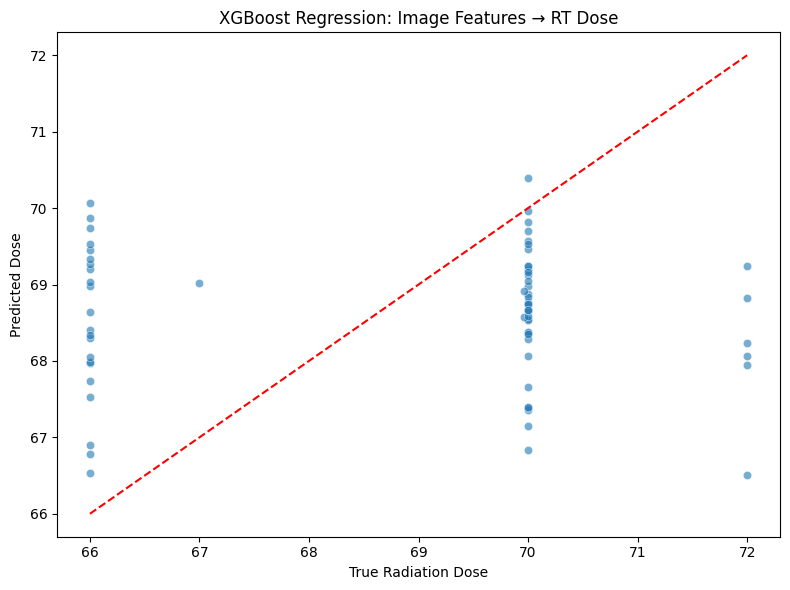

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor

# 1️⃣ Load data
image_features = pd.read_csv("resnet_features_by_patient.csv")  # Contains PatientID + 512 features
clinical = pd.read_csv("clinical1.csv")  # Must contain patient ID + RT dose column

# Drop unnecessary columns
columns_to_drop = [
    
    "TCIA Radiomics dummy ID of Merged updated ASRM V2",
    "Radiation Treatment_duration",
    "Radiation treatment_number of fractions",
    "Radiation treatment_dose per fraction"
]
clinical = clinical.drop(columns=[col for col in columns_to_drop if col in clinical.columns])

# 2️⃣ Merge using PatientID
merged = pd.merge(
    image_features,
    clinical,
    left_on="PatientID",
    right_on="TCIA Radiomics dummy ID of To_Submit_Final"
)

# 3️⃣ Prepare input/output
X = merged.iloc[:, 1:513]  # 512 image features (exclude 'PatientID')
y = merged['Total prescribed Radiation treatment dose']

# 4️⃣ Split into train and test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5️⃣ XGBoost Regressor
model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)

# 6️⃣ Cross-validation on training data
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=kf)
cv_mse_scores = -cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

print("✅ Cross-validation R² scores:", cv_r2_scores)
print("✅ Cross-validation MSE scores:", cv_mse_scores)
print(f"📊 Mean CV R²: {cv_r2_scores.mean():.3f}")
print(f"📉 Mean CV MSE: {cv_mse_scores.mean():.3f}")

# 7️⃣ Train on full training set
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 8️⃣ Evaluate on test set
print("\n📊 Test Results:")
print(f"📈 R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"📉 MSE     : {mean_squared_error(y_test, y_pred):.3f}")
print(f"📉 MAE     : {mean_absolute_error(y_test, y_pred):.3f}")

# 9️⃣ Plot predictions vs ground truth
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Radiation Dose")
plt.ylabel("Predicted Dose")
plt.title("XGBoost Regression: Image Features → RT Dose")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Load feature vectors + clinical target
features_df = pd.read_csv("resnet_features_by_patient.csv")  # From CNN
clinical_df = pd.read_csv("clinical1.csv")  # Must include PatientID and RT dose

# 2️⃣ Merge on Patient ID
id_col = 'TCIA Radiomics dummy ID of To_Submit_Final'  # Replace if needed
merged = pd.merge(features_df, clinical_df, left_on='PatientID', right_on=id_col)

# 3️⃣ Define features & target
X = merged.iloc[:, 1:513]  # 512 features
y = merged['Total prescribed Radiation treatment dose']

# 4️⃣ Split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5️⃣ Train XGBoost with 5-fold CV
model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=kf)

# 6️⃣ Train on full training set and evaluate
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 7️⃣ Results
print("\n✅ Cross-validation R² scores:", cv_scores)
print(f"✅ Mean CV R²: {cv_scores.mean():.3f}")
print(f"\n📊 Test MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"📈 Test R² : {r2_score(y_test, y_pred):.3f}")

# 8️⃣ Plot true vs predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True RT Dose")
plt.ylabel("Predicted RT Dose")
plt.title("XGBoost: True vs Predicted RT Dose")
plt.tight_layout()
plt.show()


In [ ]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm

# Paths
data_root = "/kaggle/input/hnscc-zip/HNSCC_data/ct_images/"
patient_dirs = [os.path.join(data_root, d) for d in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, d))]

# Use DenseNet121 pretrained
model = models.densenet121(pretrained=True)
model.classifier = torch.nn.Identity()  # Remove final FC layer
model.eval()

# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean/std
                         std=[0.229, 0.224, 0.225])
])

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Storage
all_features = []

# Extract features for each patient
for patient_path in tqdm(patient_dirs, desc="Extracting DenseNet Features"):
    patient_id = os.path.basename(patient_path).replace("_ct_images", "")
    slice_files = sorted([os.path.join(patient_path, f) for f in os.listdir(patient_path) if f.endswith(".png")])
    
    slice_features = []
    for slice_path in slice_files:
        try:
            image = Image.open(slice_path).convert("RGB")
            image = transform(image).unsqueeze(0).to(device)
            with torch.no_grad():
                feature = model(image).cpu().numpy().squeeze()
            slice_features.append(feature)
        except:
            continue

    if len(slice_features) > 0:
        patient_feature = np.mean(slice_features, axis=0)  # Global Average Pooling across slices
        all_features.append([patient_id] + patient_feature.tolist())

# Save as CSV
feature_df = pd.DataFrame(all_features)
feature_df.columns = ["PatientID"] + [f"f{i+1}" for i in range(1024)]
feature_df.to_csv("densenet_features_by_patient.csv", index=False)
print("✅ Saved: densenet_features_by_patient.csv")


In [ ]:
# Re-import required packages after kernel reset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Re-load uploaded files
image_features = pd.read_csv("densenet_features_by_patient.csv")
clinical = pd.read_csv("clinical1.csv")

# Merge on Patient ID
merged = pd.merge(
    image_features,
    clinical,
    left_on="PatientID",
    right_on="TCIA Radiomics dummy ID of To_Submit_Final"
)

# Prepare input and output
X = merged.drop(columns=["PatientID", "TCIA Radiomics dummy ID of To_Submit_Final"])
y = merged["Total prescribed Radiation treatment dose"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models
models = {
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42),
    "MLP": MLPRegressor(hidden_layer_sizes=(128,), max_iter=500, random_state=42)
}

# Results
results = []
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        "Model": name,
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R²": r2_score(y_test, y_pred)
    })
    predictions[name] = y_pred

# Create results dataframe
results_df = pd.DataFrame(results).sort_values(by='R²', ascending=False)

# Plot predictions
plt.figure(figsize=(15, 4))
for i, (name, y_pred) in enumerate(predictions.items()):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("True Dose")
    plt.ylabel("Predicted Dose")
    plt.title(name)
plt.tight_layout()
plt.show()

import ace_tools as tools; tools.display_dataframe_to_user(name="Regression Model Comparison (DenseNet Features)", dataframe=results_df)
